# 1. Import Modules

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_ticker = pd.read_csv("ticker.csv")
print(df_ticker.head()) 
print(df_ticker.shape)

                       Name    ID Ticker Exchange
0  C. H. Robinson Worldwide  2239   CHRW   NASDAQ
1               Kraft Heinz  2161    KHC   NASDAQ
2                  Fastenal  2316   FAST   NASDAQ
3                    Splunk   237   SPLK   NASDAQ
4                    Kroger  1813     KR     NYSE
(711, 4)


In [33]:
df_ticker_description = pd.read_csv("ticker_description.csv")
print(df_ticker_description.head())

     Header                                        Description
0      Name                           The name of the company.
1        ID               A unique numeric ID for the company.
2    Ticker  The ticker symbol for the company's shares on ...
3  Exchange  The exchange on which the company's shares are...


In [34]:
df_core = pd.read_csv("core.csv")
print(df_core.head())
print(df_core.shape)

            Name   ID        Country                     Website  \
0  Accenture Plc  803        Ireland  https://www.accenture.com/   
1      Cognizant  806  United States   https://www.cognizant.com   
2         Amazon   23  United States           http://amazon.com   
3            IBM  115  United States         http://www.ibm.com/   
4      Microsoft  163  United States    http://www.microsoft.com   

                                       Groups         Region   Stage  \
0                                     S&P 500         Europe  Mature   
1                                     S&P 500  North America  Mature   
2                    S&P 500, Global Big Tech  North America  Mature   
3                    S&P 500, Global Big Tech  North America  Mature   
4  S&P 500, Global Big Tech, GenAI Contenders  North America  Mature   

                   Sector                                        Description  \
0  Software & IT Services  Accenture is a professional services company, ...  

In [35]:
df_core_description = pd.read_csv("core_description.csv")
print(df_core_description.head())

  Variable Name                                        Description
0          Name                 The canonical name of the company.
1            ID               A unique numeric ID for the company.
2       Country  The country where the company's headquarters i...
3       Website                            The company's homepage.
4        Groups          Thematic groups that include the company.


# 2. Summarise and report AI growth for companies listed in different stock exchanges

An initial look through the ticker csv, we can see that a company can be listed under multiple stock exchanges

In [36]:
# We first sort by different stock exchanges


# Get unique Name and Exchange pairs from df_ticker
df_unique_listings = df_ticker.drop_duplicates(subset=["Name", "Exchange"])



print(df_unique_listings.head())
print(df_unique_listings.shape)

                       Name    ID Ticker Exchange
0  C. H. Robinson Worldwide  2239   CHRW   NASDAQ
1               Kraft Heinz  2161    KHC   NASDAQ
2                  Fastenal  2316   FAST   NASDAQ
3                    Splunk   237   SPLK   NASDAQ
4                    Kroger  1813     KR     NYSE
(594, 4)


In [37]:
# Number of companies per Exchange
company_count = df_unique_listings['Exchange'].value_counts()
print(company_count)

Exchange
NYSE      408
NASDAQ    166
HKG        14
SSE         3
SZSE        3
Name: count, dtype: int64


In [38]:
# Combine df_unique_listings with Columns regarding to AI metrics where name matches in df_core

ai_metrics = ["AI_Publications", "AI_Growth", "Total_Publications", "AI patents", 
              "Patents_Growth", "Granted_AI_patents"]

df_unique_listings = df_unique_listings.merge(df_core, on="Name", how="left")

print(df_unique_listings.head())
print(df_unique_listings.shape)

                       Name  ID_x Ticker Exchange    ID_y        Country  \
0  C. H. Robinson Worldwide  2239   CHRW   NASDAQ  2239.0  United States   
1               Kraft Heinz  2161    KHC   NASDAQ  2161.0  United States   
2                  Fastenal  2316   FAST   NASDAQ  2316.0  United States   
3                    Splunk   237   SPLK   NASDAQ   237.0  United States   
4                    Kroger  1813     KR     NYSE  1813.0  United States   

                              Website   Groups         Region   Stage  ...  \
0         https://www.chrobinson.com/  S&P 500  North America  Mature  ...   
1  https://www.kraftheinzcompany.com/  S&P 500  North America  Mature  ...   
2           https://www.fastenal.com/  S&P 500  North America  Mature  ...   
3              https://www.splunk.com      NaN  North America  Mature  ...   
4             https://www.kroger.com/  S&P 500  North America  Mature  ...   

  Knowledge_Representation Language_Processing  Measuring_n_Testing  \
0  

In [39]:
# We get the average AI_Growth grouped by Exchange name
summary = df_unique_listings.groupby('Exchange')['AI_Growth'].mean().reset_index()
summary = summary.sort_values('AI_Growth')
print(summary)




  Exchange  AI_Growth
2     NYSE   2.459936
1   NASDAQ  23.437227
4     SZSE  39.623173
0      HKG  62.188675
3      SSE  82.986111


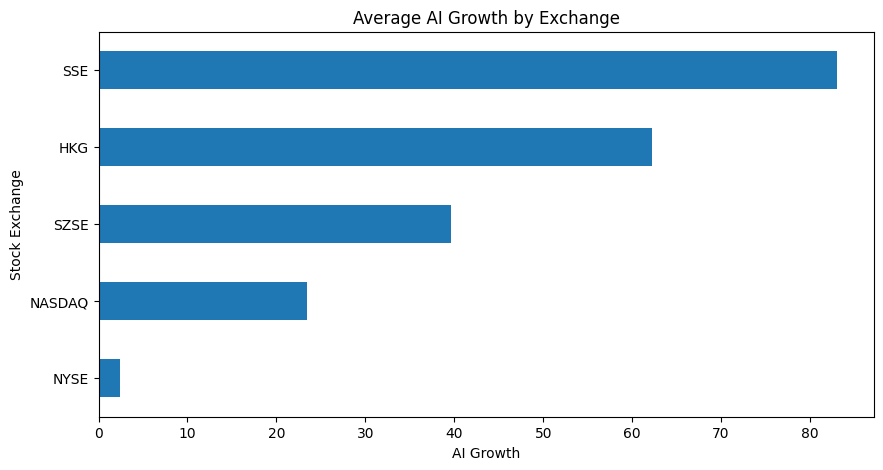

In [40]:

summary['AI_Growth'].sort_values().plot(kind='barh', figsize=(10, 5), title="Average AI Growth by Exchange")
plt.xlabel("AI Growth")
plt.ylabel("Stock Exchange")
plt.yticks(ticks=range(len(summary)), labels=summary['Exchange'], fontsize=10)
plt.show()

Despite NYSE having the highest number of companies listed (408), with a total count significantly larger than other exchanges, the average AI growth for companies listed on NYSE is the lowest at 2.46%

NASDAQ exchange, with 166 companies listed, exhibits a stronger AI growth rate of 23.44%

HKG has the third highest AI growth rate of 62.19% with only 14 companies making it less reliable.

SZSE and SSE although they have high AI growth rate at 39.62% and 82.99% respectively, they are only represented by only 3 companies each, making it not reliable due to low sample size.

# 3. Further analysis

In [41]:
exchange_ai_growth = df_unique_listings.groupby('Exchange')['AI_Growth']
ai_growth_extremes = exchange_ai_growth.agg(['min', 'max']).reset_index()

print(ai_growth_extremes)

  Exchange         min         max
0      HKG  -25.000000  263.958333
1   NASDAQ -100.000000  508.333333
2     NYSE -100.000000  650.740741
3      SSE  -16.666667  263.958333
4     SZSE   30.532365   51.143791


Upon further analysis of the extreme bounds, it can be seen that there are companies that completely abandon AI, where -100 can be seen 

In [42]:
# Define a function to remove outliers per group
def remove_outliers(group):
    """
        Removes outliers from a group based on the Interquartile Range (IQR) method by filtering values that lie outside 1.5 times the IQR below Q1 or above Q3.
    """
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group >= lower_bound) & (group <= upper_bound)]

# Remove outliers from AI_Growth within each Exchange and those that completely abandon AI

df_filtered = df_unique_listings[df_unique_listings["AI_Growth"] > -100]  # First remove the abandoned AI (-100)
df_filtered.loc[:, "AI_Growth"] = df_filtered.groupby("Exchange")["AI_Growth"].transform(remove_outliers)



# print(df_filtered.head())


# min and max AI_Growth after outlier removal
ai_growth_extremes_filtered = df_filtered.groupby('Exchange')['AI_Growth'].agg(['min', 'max', 'count']).reset_index()
print(ai_growth_extremes_filtered)

  Exchange        min         max  count
0      HKG  18.074120   67.608796     10
1   NASDAQ -66.666667  128.888889     59
2     NYSE -75.000000  150.000000    122
3      SSE -16.666667  263.958333      3
4     SZSE  30.532365   51.143791      3


In [43]:
summary = df_filtered.groupby('Exchange')['AI_Growth'].mean().reset_index()

# 6. Sort the summary by average AI_Growth
summary = summary.sort_values('AI_Growth')

print("Summary of Average AI Growth by Exchange:")
print(summary)

Summary of Average AI Growth by Exchange:
  Exchange  AI_Growth
2     NYSE  27.762124
1   NASDAQ  28.346513
4     SZSE  39.623173
0      HKG  46.486481
3      SSE  82.986111


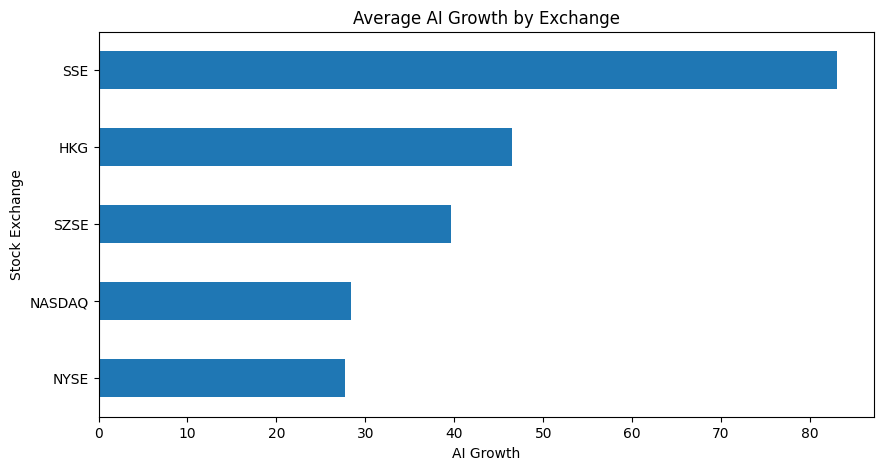

In [44]:
summary['AI_Growth'].sort_values().plot(kind='barh', figsize=(10, 5), title="Average AI Growth by Exchange")
plt.xlabel("AI Growth")
plt.ylabel("Stock Exchange")
plt.yticks(ticks=range(len(summary)), labels=summary['Exchange'], fontsize=10)
plt.show()

By applying outlier removel, we provides a more accurate and reliable view of AI growth across exchanges.

NASDAQ and NYSE, with 59 and 122 companies represented respectively, have growth rates of 28.35% and 27.76%. The similarities in these rates may reflect the broader adoption of AI across companies listed on these exchanges.

However, exchanges like HKG, SSE, and SZSE, which have fewer than 10 companies represented, may not provide reliable insights due to the limited sample size, making them less reliable as indicators of broader trends